# Imports

In [7]:
import numpy as np
import seaborn as sns
import pandas as pd


import matplotlib.pyplot as plt

from tqdm import tqdm

import keijzer_exogan as ke

%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"} # Make sure the axis background of plots is white, this is usefull for the black theme in JupyterLab
sns.set()

# Load chunk
X[0] is a dict from regular chunk  
X[0][0] is a dict from .npy selection  

In [8]:
%%time
dir_ = '/datb/16011015/ExoGAN_data//'

X = np.load(dir_+'selection/first_chunks_25_percent.npy')
X = X.flatten()

np.random.seed(23) # Set seed for the np.random functions

# Shuffle X along the first axis to make the order of simulations random
np.random.shuffle(X) # note that X = np.rand.... isn't required

CPU times: user 40.7 s, sys: 8.58 s, total: 49.3 s
Wall time: 49.4 s


In [9]:
wavelengths = ke.load_wavelengths()

## Test ASPA run

100%|██████████| 32/32 [00:06<00:00,  2.78it/s]


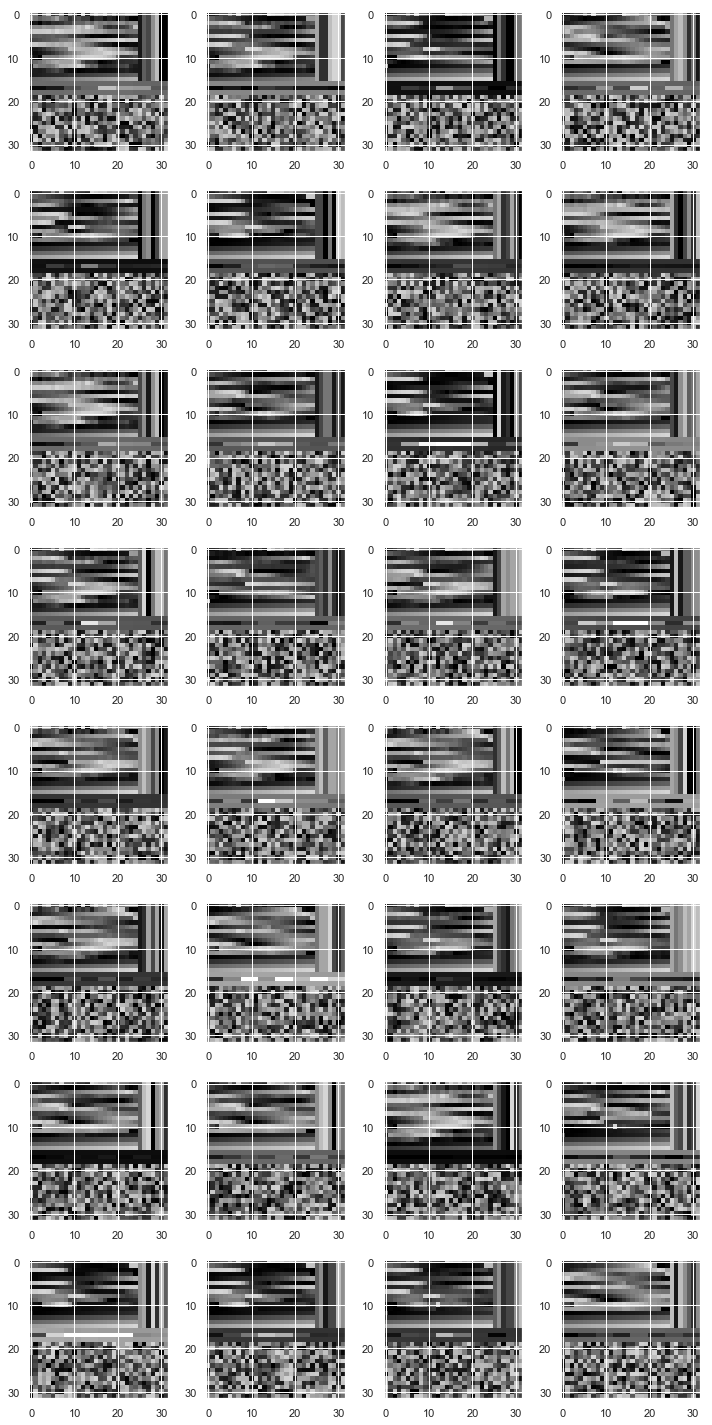

In [10]:
plt.figure(figsize=(10,20))

for i in tqdm(range(8*4)):
    image = ke.ASPA_v3(X[i], wavelengths)
    

    plt.subplot(8, 4, i+1)
    plt.imshow(image, cmap='gray', vmin=0, vmax=1.2)
    plt.tight_layout()

# Creating images from all simulations in the chunk

In [11]:
from multiprocessing import Pool

In [21]:
data = [(X[i], wavelengths) for i in tqdm(range(len(X)))] # input to f must be a tuple

100%|██████████| 1250000/1250000 [00:03<00:00, 391909.80it/s]


In [22]:
def f(t):
    X_i , wavelengths = t
    image = ke.ASPA_v3(X_i, wavelengths)
    image = image.reshape(1,32,32)
    return image

In [23]:
%%time
pool = Pool() # server has 2x 12 cores -> Pool(processes=24)
results = pool.map(f, data, chunksize=1)

CPU times: user 5min 12s, sys: 1min 19s, total: 6min 31s
Wall time: 10min 47s


In [24]:
%%time
pool.close()
pool.join()
#pool.terminate() # not nice but meh, pool.join() gets stuck... https://stackoverflow.com/questions/15314189/python-multiprocessing-pool-hangs-at-join

CPU times: user 7.23 ms, sys: 5.3 ms, total: 12.5 ms
Wall time: 2.63 s


In [28]:
len(results)

1250000

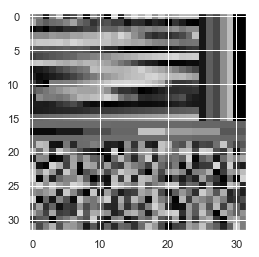

In [29]:
plt.imshow(results[0][0, :, :], cmap='gray', vmin=0, vmax=1.2)

In [31]:
%%time
images = np.array(results)

CPU times: user 2.42 s, sys: 8.41 s, total: 10.8 s
Wall time: 10.9 s


# Saving this array to disk

In [32]:
%%time
np.save(dir_+'selection/last_chunks_25_percent_images_v2.npy', images)

CPU times: user 837 ms, sys: 6.02 s, total: 6.86 s
Wall time: 14.4 s


# Test loading and visualization

In [33]:
print('DONE')

DONE


In [34]:
print("DONE")

DONE


In [35]:
print("DONE")

DONE


In [37]:
images = np.load(dir_+'selection/first_chunks_25_percent_images_v2.npy')

FileNotFoundError: [Errno 2] No such file or directory: '/datb/16011015/ExoGAN_data//selection/first_chunks_25_percent_images_v2.npy'

In [ ]:
images.shape

In [ ]:
plt.imshow(images[0,0,:,:])

In [ ]:
plt.figure(figsize=(10,20))

for i in range(8*4):
    plt.subplot(8, 4, i+1)
    plt.imshow(images[i,0,:,:], cmap='gnuplot2')
    plt.tight_layout()

# Randomly mask pixels from the encoded spectrum

In [ ]:
image = images[0, 0, :, :]
plt.imshow(image)

In [ ]:
# image[:23, :23] is the encoded spectrum.
t = image.copy()
print(t.shape)
#t[:23, :23] = 0
plt.imshow(t)

# Random uniform dropout

In [ ]:
t = image.copy()
dropout = 0.9

for i in range(24): # loop over rows
    for j in range(24): # loop over cols
        a = np.random.random() # random uniform dist 0 - 1
        if a < dropout:
            t[i-1:i, j-1:j] = 0
        else:
            pass

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(t)

In [ ]:
# image[:23, :23] is the encoded spectrum.
t = image.copy()

#t[:23, :23] = 0
plt.imshow(t)
t.shape

# Range dropout

In [ ]:
# TODO: Mask everything but the visible spectrum

def mask_image(image, visible_length, random_visible_spectrum=True):
    """
    Masks everything in an input image, apart from the start to visible_length. 
    
    start = start wavelength/index value of the visible (non masked) spectrum
    visible_length = length of the visible spectrum (in pixels)
    output: masked_image
    """

    image_masked = image.copy()
    
    spectrum_length = 23*23 # length of spectrum in ASPA
    start_max = spectrum_length - visible_length # maximum value start can have to still be able to show spectrum of length visible_length
    start = np.random.randint(0, start_max)

    # start stop index to mask before the visible (not masked) spectrum / sequence

    stop = start + visible_length # stop index of unmasked sequence

    spectrum = image_masked[:23, :23].flatten() # flatten the spectrum
    spectrum[:start] = 0
    spectrum[stop:] = 0
    spectrum = spectrum.reshape(23, 23)

    #t[:, :] = 0

    image_masked[:23, :23] = spectrum

    image_masked[:, 29:] = 0 # right side params
    image_masked[29:, :] = 0 # bottom params
    image_masked[23:, 23:] = 0 # h2o

    image_masked = image_masked.reshape(1, 32, 32) # add the channel dimension back 
    
    return image_masked


image = images[0, 0, :, :].copy()
visible_length = 46 # length of the visible (not to mask) spectrum

image_masked = mask_image(image, visible_length)
plt.imshow(image_masked[0, :, :])

## Also mask params and h2o
Leaving min max values for now (they will get updated anyway)